## fine-tuning

In [1]:
'''
数据目录结构：
data/
     train3/   #去除异常图片后的训练数据（连接文件）
        dog/    #9983张图片
            dog.0.jpg
            dog.1.jpg
            ...
        cat/    #9961张图片
            cat.0.jpg
            cat.1.jpg
            ...
    validation/  #去除异常图片后的验证数据（连接文件）
        dog/   #2496张图片
            dog001.jpg
            dog002.jpg
            ...
        cat/   #2490张图片
            cat001.jpg
            cat002.jpg
            ...
    test/     
        test/  #测试集数据，12500张图片
            1.jpg
            2.jpg
            ...
'''
import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.optimizers import *
from keras.utils import *

# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = 'data/train3'
valid_data_dir = 'data/validation'
test_data_dir= 'data/test'

nb_train_samples = 19944
nb_validation_samples = 4986
batch_size = 72   #19944/72=277  4986/72=69.25


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#构造模型
x_input = Input((299, 299, 3))
x_input = Lambda(xception.preprocess_input)(x_input)

base_model = Xception(input_tensor=x_input, weights='imagenet', include_top=False, pooling = 'avg')

for layer in base_model.layers:
    layer.trainable = False
    
x = Dropout(0.5)(base_model.output)
x = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001))(x)
model = Model(base_model.input, x)

adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])

gen = ImageDataGenerator(rotation_range=30,  #旋转数据增强
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
val_gen = ImageDataGenerator()
train_generator = gen.flow_from_directory(train_data_dir, (299, 299), shuffle=True, 
                                          batch_size=64,class_mode='binary')
valid_generator = val_gen.flow_from_directory(valid_data_dir, (299, 299), shuffle=True, 
                                          batch_size=32,class_mode='binary')

for i in range(len(model.layers)):
    print(i,model.layers[i].name)


Found 19944 images belonging to 2 classes.
Found 4986 images belonging to 2 classes.
0 input_1
1 lambda_1
2 block1_conv1
3 block1_conv1_bn
4 block1_conv1_act
5 block1_conv2
6 block1_conv2_bn
7 block1_conv2_act
8 block2_sepconv1
9 block2_sepconv1_bn
10 block2_sepconv2_act
11 block2_sepconv2
12 block2_sepconv2_bn
13 conv2d_1
14 block2_pool
15 batch_normalization_1
16 add_1
17 block3_sepconv1_act
18 block3_sepconv1
19 block3_sepconv1_bn
20 block3_sepconv2_act
21 block3_sepconv2
22 block3_sepconv2_bn
23 conv2d_2
24 block3_pool
25 batch_normalization_2
26 add_2
27 block4_sepconv1_act
28 block4_sepconv1
29 block4_sepconv1_bn
30 block4_sepconv2_act
31 block4_sepconv2
32 block4_sepconv2_bn
33 conv2d_3
34 block4_pool
35 batch_normalization_3
36 add_3
37 block5_sepconv1_act
38 block5_sepconv1
39 block5_sepconv1_bn
40 block5_sepconv2_act
41 block5_sepconv2
42 block5_sepconv2_bn
43 block5_sepconv3_act
44 block5_sepconv3
45 block5_sepconv3_bn
46 add_4
47 block6_sepconv1_act
48 block6_sepconv1
49 bl

'\nmodel,train_generator,valid_generator = build_model(Xception, (img_width, img_height), train_data_dir, valid_data_dir, xception.preprocess_input)\n'

In [3]:
#训练模型并保存在验证集上损失函数最小的权重
filepath="xception-best_weight_freeze.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples//batch_size,
        epochs=10,
        validation_data=valid_generator,
        validation_steps=nb_validation_samples//batch_size,
        callbacks = callbacks_list)


Epoch 1/10
277/277 [==============================] - 469s 2s/step - loss: 0.4785 - acc: 0.8420 - val_loss: 0.3004 - val_acc: 0.9774

Epoch 00001: val_loss improved from inf to 0.30042, saving model to xception-best_weight_freeze.h5
Epoch 2/10
277/277 [==============================] - 459s 2s/step - loss: 0.2755 - acc: 0.9534 - val_loss: 0.2014 - val_acc: 0.9823

Epoch 00002: val_loss improved from 0.30042 to 0.20144, saving model to xception-best_weight_freeze.h5
Epoch 3/10
277/277 [==============================] - 454s 2s/step - loss: 0.2007 - acc: 0.9626 - val_loss: 0.1613 - val_acc: 0.9832

Epoch 00003: val_loss improved from 0.20144 to 0.16126, saving model to xception-best_weight_freeze.h5
Epoch 4/10
277/277 [==============================] - 452s 2s/step - loss: 0.1614 - acc: 0.9669 - val_loss: 0.1414 - val_acc: 0.9832

Epoch 00004: val_loss improved from 0.16126 to 0.14141, saving model to xception-best_weight_freeze.h5
Epoch 5/10
277/277 [==============================] - 45

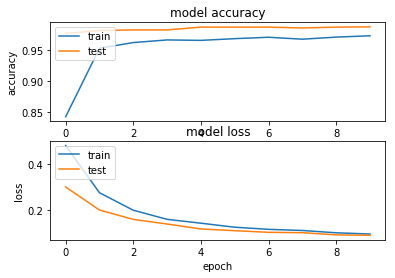

In [4]:
#可视化学习曲线
show_learning_curve(history)

In [7]:
def predict_on_model(n, width, heigth, test_data_dir, model, weight, output_name):
    x_test = np.zeros((n,width,heigth,3),dtype=np.uint8)

    for i in tqdm(range(n)):
        img = load_img(test_data_dir+"/test/"+'/%d.jpg' % (i+1)) 
        x_test[i,:,:,:] = img_to_array(img.resize((width,heigth),Image.ANTIALIAS))
    
    model.load_weights(weight)
    y_test = model.predict(x_test, verbose=1)
    y_test = y_test.clip(min=0.005, max=0.995)
    
    df = pd.read_csv("sample_submission.csv")
    for i in tqdm(range(n)):
        df.set_value(i, 'label', y_test[i])
    df.to_csv(output_name, index=None)
    df.head(10)

In [8]:
predict_on_model(12500, 299, 299, test_data_dir, model, "xception-best_weight_freeze.h5", "pred-xception-freeze-2.csv")

100%|██████████| 12500/12500 [02:44<00:00, 76.11it/s]


12500/12500 [==============================] - 301s 24ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
100%|██████████| 12500/12500 [00:00<00:00, 142531.92it/s]


## 开放部分层fine-tuning
开发97层以上，重新训练权重

In [10]:
for layer in model.layers:
    layer.trainable = False
    
for layer in model.layers[97:]:
    layer.trainable = True

model.load_weights('xception-best_weight_freeze.h5')

model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [12]:
#训练模型并保存在验证集上损失函数最小的权重
filepath="xception-fine-tuning-1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples//batch_size,
        epochs=5, 
        validation_data=valid_generator,
        validation_steps=nb_validation_samples//batch_size,
        callbacks = callbacks_list)


Epoch 1/5
277/277 [==============================] - 561s 2s/step - loss: 0.0202 - acc: 0.9944 - val_loss: 0.0201 - val_acc: 0.9955

Epoch 00001: val_loss improved from inf to 0.02011, saving model to xception-fine-tuning-1.h5
Epoch 2/5
277/277 [==============================] - 559s 2s/step - loss: 0.0176 - acc: 0.9954 - val_loss: 0.0122 - val_acc: 0.9968

Epoch 00002: val_loss improved from 0.02011 to 0.01216, saving model to xception-fine-tuning-1.h5
Epoch 3/5
277/277 [==============================] - 560s 2s/step - loss: 0.0141 - acc: 0.9967 - val_loss: 0.0100 - val_acc: 0.9982

Epoch 00003: val_loss improved from 0.01216 to 0.01005, saving model to xception-fine-tuning-1.h5
Epoch 4/5
277/277 [==============================] - 560s 2s/step - loss: 0.0121 - acc: 0.9967 - val_loss: 0.0148 - val_acc: 0.9964

Epoch 00004: val_loss did not improve from 0.01005
Epoch 5/5
277/277 [==============================] - 561s 2s/step - loss: 0.0121 - acc: 0.9972 - val_loss: 0.0121 - val_acc: 0.

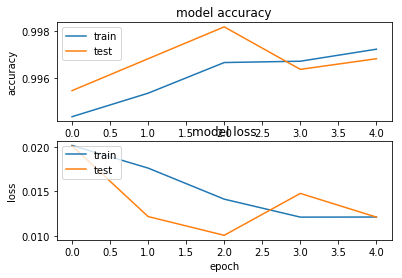

In [13]:
#可视化学习曲线
show_learning_curve(history)

In [15]:
predict_on_model(12500, 299, 299, test_data_dir, model, "xception-fine-tuning-1.h5", "pred-xception-fine-tuning-1.csv")

100%|██████████| 12500/12500 [01:27<00:00, 143.13it/s]


12500/12500 [==============================] - 309s 25ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
100%|██████████| 12500/12500 [00:00<00:00, 148283.24it/s]
